In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random as rng
%matplotlib inline

## Tip: use `tqdm` to get a progress bar

For calculations that run over many iterations over a longer perioid of time, it's often helpful to know how long you'll be waiting for the code to finish. `tqdm` is a useful Python package for doing this -- it provides a progress bar and time remaining estimate for any loop iteration

In [2]:
from tqdm import tqdm
from time import sleep

for i in tqdm(range(100)):
    sleep(.05)  # do some 'work' every iteration

100%|██████████| 100/100 [00:05<00:00, 19.48it/s]


## Problem 1

In [3]:
# Uniform Lattice creation
def normal_lattice(N, M, value):
    '''
    This function returns an N (rows) x M (columns) lattice with identical values value
    '''
    return np.full((N, M), value)

For the random lattice, we'll use `numpy.random.choice`, which randomly chooses a number from a provided set (-1 and 1 in this case)

In [4]:
# Random Lattice creation
def random_lattice(N, M):
    '''
    This function returns an N (rows) x M (columns) lattice with randomized spin values 0 or 1
    '''
    return rng.choice((-1, 1), (N, M))

For the visualization function, we define a `plot_lattice` function that takes a lattice and an optional axis argument `ax` as input. This allows additional flexibility, e.g. if we want to plot lattices in multiple subplots of the same figure, we can pass in the axis object for each subplot. `ax` will default to the current axis. Note the use of `ax=None` and `python if ax is None` -- this is a common approach for handling default arguments that require a function call to default initialize ([this blog post](https://graysonkoonce.com/always-use-none-for-default-args-in-python) provides another example of why you want to do this)

In [5]:
# create a custom colormap from a list of colors 
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['white', 'green'])

# plot a lattice
def plot_lattice(lattice, ax=None):
    """
    Create a visualization of a lattice, and return the image
    
    Arguments:
        lattice    N x M lattice to plot
        ax         matplotlib axis instance (default: current axis)
    """
    if ax is None:
        ax = plt.gca()   # gca = 'get current axis'
    
    # for aesthetics, draw black edges for smaller lattices (N,M < 25) 
    edgecolor = 'black' if max(lattice.shape) < 25 else None
    
    im = ax.pcolormesh(lattice.copy(), cmap=cmap, edgecolor=edgecolor, vmax=1, vmin=-1)
    ax.set_aspect('equal')  # we want squares, not rectangles
    
    return im

Let's test our functions, using the `ax` argument with two subplots

Text(0.5,1,'normal lattice')

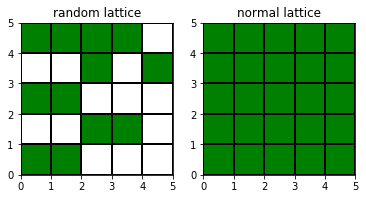

In [6]:
fig, axes = plt.subplots(ncols=2)

lattice = random_lattice(5, 5)
plot_lattice(lattice, ax=axes[0])
axes[0].set_title('random lattice')

lattice = normal_lattice(5, 5, value=1)
plot_lattice(lattice, ax=axes[1])
axes[1].set_title('normal lattice')

## Problem 2

`random_select` and `flip_spin` are defined:

In [7]:
def random_select(lattice):
    """
    Randomly choose a position (i,j) in the lattice
    """
    N, M = lattice.shape
    i = rng.randint(0, N)
    j = rng.randint(0, M)
    
    return (i, j)

In [8]:
#NOTE: this function mutates the lattice that is passed in
def flip_spin(lattice, i, j):
    """
    Flip the spin of lattice site (i,j) and return its new value
    """
    lattice[i,j] *= -1
    return lattice[i,j]

Let's try this on a random lattice:

Text(0.5,0.5,'flipped')

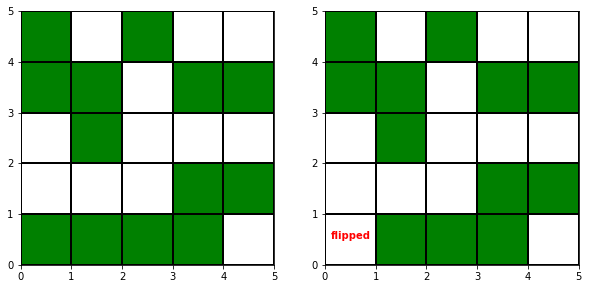

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(10,6))

# create initial lattice
lattice = random_lattice(5, 5)
plot_lattice(lattice, ax=axes[0])

# randomly flip one site
i, j = random_select(lattice)
flip_spin(lattice, i, j)
plot_lattice(lattice, ax=axes[1])
axes[1].text(j+0.5, i+0.5, 'flipped', ha='center', color='red', weight='bold')

## Problem 3

In [10]:
def combined_spin_state(lattice, i, j):
    """
    Determine the combined spin state due to nearest neighbors around lattice site (i,j)
    Periodic BC are used for lattice sites at the edge
    """
    N, M = lattice.shape
    
    total = lattice[(i+1)%N, j]
    total += lattice[(i-1)%N, j]
    total += lattice[i, (j+1)%M]
    total += lattice[i, (j-1)%M]
    
    return total

In [11]:
# determine the combined spin state of the lattice site that was just flipped
combined_spin_state(lattice, i, j)

0

## Problem 4

The local energy at $(i,j)$ is determined by the combined spin state around $(i,j)$ and the spin state at $(i,j)$.

In [12]:
def local_energy(lattice, i, j, J=1, H=0):
    """
    Determine the local energy of the lattice at site (i,j) with coupling
    coefficient J and external field strength H
    """
    combined = combined_spin_state(lattice, i, j)
    energy = (-J*combined - H)*lattice[i,j]
    return energy

The total energy is then given by a sum over all the local energies. We'll call this function `total_energy_python`, as the explicit `for` loop, while very Pythonic, is less performant.

In [13]:
def total_energy_python(lattice, J=1, H=0):
    """
    Determine the total energy of the lattice with coupling
    coefficient J and external field strength H
    """
    N, M = lattice.shape
    
    energy = 0
    for i in range(N):
        for j in range(M):
            energy += local_energy(lattice, i, j, J, H)
            
    return energy

We can instead compute the local energy for the entire lattice more efficiently using the `numpy.roll` function to shift the lattice 4 times.

In [14]:
def energy_density_numpy(lattice, J=1, H=0):
    """
    Determine the energy density of the lattice with coupling
    coefficient J and external field strength H
    """
    N, M = lattice.shape
    
    combined = np.roll(lattice, +1, axis=0) \
             + np.roll(lattice, -1, axis=0) \
             + np.roll(lattice, +1, axis=1) \
             + np.roll(lattice, -1, axis=1) \
    
    energy_density = (-J*combined - H)*lattice
            
    return energy_density

The total energy is then a sum over the energy density, which will use as the input argument:

In [15]:
def total_energy_numpy(energy_density):
    """
    Determine the total energy of the lattice by summing the engery density
    """
    return np.sum(energy_density)

We also have a numpy function to compute the energy variance (that is, the specific heat) for a given energy density.

In [16]:
def energy_variance(energy_density, T=1):
    """
    Determine the variance of the energy of the lattice.
    Normalize by the temperature if specified.
    """
    return np.var(energy_density)/T**2

Let's test that our two total energy functions give the same result:

In [17]:
J, H = 1, 0
lattice = random_lattice(50, 50)

print('Python version: ', total_energy_python(lattice, J, H))

energy_density = energy_density_numpy(lattice, J, H)
print('NumPy version:  ', total_energy_numpy(energy_density))

Python version:  216
NumPy version:   216


Let's check the performance of the two for this 50 x 50 lattice. The numpy version runs about 50 times faster than the Python version:

In [18]:
%timeit total_energy_python(lattice, J, H)

4.03 ms ± 44.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
%timeit total_energy_numpy(energy_density_numpy(lattice, J, H))

78.4 µs ± 237 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Compute the energy of the lattice with a random lattice, all spin up, and all spin down:

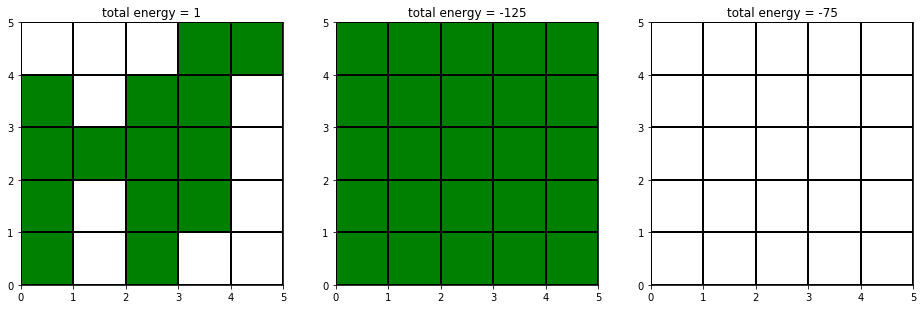

In [20]:
fig, axes = plt.subplots(ncols=3, figsize=(16,5))

N, M = 5, 5
J, H = 1, 1
lattices = [random_lattice(N, M),
            normal_lattice(N, M, 1),
            normal_lattice(N, M, -1)]

for i in range(3):
    plot_lattice(lattices[i], ax=axes[i])
    axes[i].set_title('total energy = {}'.format(total_energy_numpy(energy_density_numpy(lattices[i], J, H))))

## Problem 5

The magnetization is simply a sum over all the lattice sites. Magnetization per spin is the magnetization normalized by the total number of lattice sites, so that the values are between $-1$ and $+1$ for any lattice

In [21]:
def magnetization(lattice):
    return np.sum(lattice)

In [22]:
def magnetization_per_spin(lattice):
    M = magnetization(lattice)
    total = np.prod(lattice.shape)
    
    return M/total

## Problem 6

Using the functions defined above, we define an `update_lattice` function that runs the Metropolis algorithm for a single step. The energy difference before flip and after flip can be calculated by simply looking at the current local energy at $(i,j)$, $\Delta E = -2 E_\text{local}(i,j)$. This function will return $(\Delta E, \Delta M)$, the change in the energy and magnetization. By doing this, we can increase the performance of calculating $E$ and $M$ over many steps -- we only have to keep track of what changes, and we can avoid iterating over the whole lattice.

In [23]:
def update_lattice(lattice, T, J=1, H=0):
    """
    Update the lattice using the Metropolis algorithm at temperature T, coupling J, and external field H
    Return (delta_energy, delta_mag), the change in the energy and magnetization
    """
    i, j = random_select(lattice)

    E = local_energy(lattice, i, j, J, H)
    delta_energy = -2*E
    delta_mag = -2*lattice[i,j]
    
    if delta_energy < 0:
        flip_spin(lattice, i, j)
    else:
        r = rng.uniform(0, 1)
        boltzman = np.exp(-delta_energy/T)
        if r < boltzman:
            flip_spin(lattice, i, j)
        else:
            delta_energy, delta_mag = 0, 0   # no flip occured, so set delta's to zero
            
    return delta_energy, delta_mag

Let's test this for a $5 \times 5$ lattice at a low temperature over 200 iterations. We expect over time for the lattice sites to be all spin up or all spin down. We first write a function that we can use to plot a series of snapshots for different temperature $T$

In [24]:
def time_series_plots(N, M, Nsteps, T):
    """
    Plot 10 snapshots of the evolution of an NxM lattice over Nsteps and temperature T
    """
    lattice = random_lattice(N, M)  # initial lattice
    history = []  # a record to store 10 snapshots of the lattice

    store_every = Nsteps // 10
    for i in tqdm(range(Nsteps)):
        update_lattice(lattice, T=T)
        
        if i % store_every == 0:
            history.append(lattice.copy())

    # plot the lattices
    fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(14,6))

    for i in range(10):
        ax = axes.flatten()[i]
        plot_lattice(history[i], ax=ax)
        ax.set_title('step = {}'.format(i*store_every))

100%|██████████| 150/150 [00:00<00:00, 29418.57it/s]


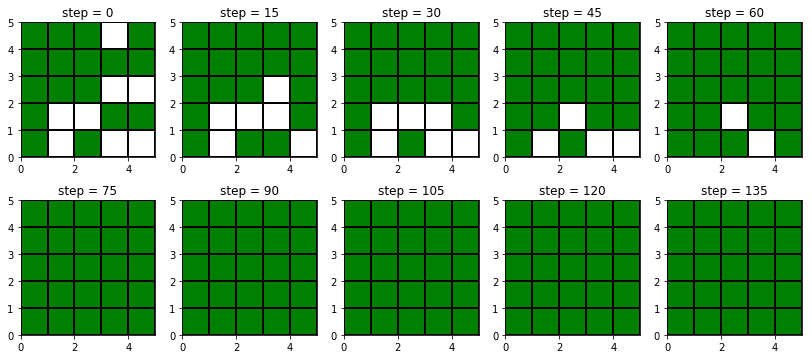

In [25]:
time_series_plots(5, 5, Nsteps=150, T=.1)

All of the spins eventually point up. If instead we use a high temperature, we expect an equal mixture of spin up and spin down even after many steps.

100%|██████████| 1500/1500 [00:00<00:00, 36256.77it/s]


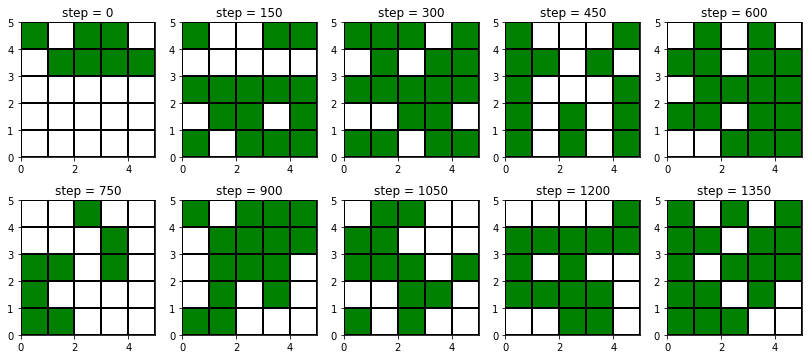

In [26]:
time_series_plots(5, 5, Nsteps=1500, T=10)

## Problem 7

As a first example, let's compute the magnetization over time for a low $T$ lattice using two methods: the `magnetization` function and the return argument from `update_lattice`. The methods are equivalent, but the latter is more performant.

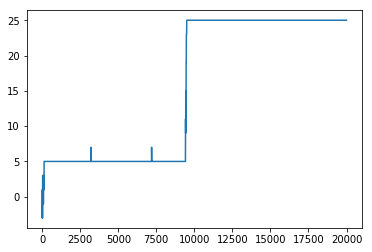

In [27]:
# call magnetization function every step
lattice = random_lattice(5, 5)
Nsteps = 20000

M = np.zeros(Nsteps, dtype=float)
for t in range(Nsteps):
    update_lattice(lattice, T=.5)
    M[t] = magnetization(lattice)

plt.plot(M)

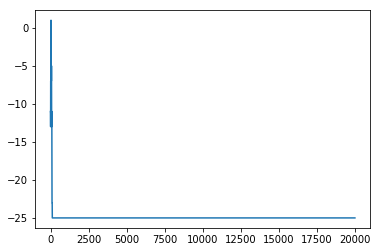

In [28]:
# instead, call magnetization only for the inital M. Store delta_M every iteration. Compute M using a cumulative sum
lattice = random_lattice(5, 5)
Nsteps = 20000

initial_M = magnetization(lattice)
delta_M = np.zeros(Nsteps)
for t in range(Nsteps):
    _, delta_M[t] = update_lattice(lattice, T=.5)

M = initial_M + np.cumsum(delta_M)
plt.plot(M)

Now we want to compute the average energy, magnetization, and specific heat as a function of the temperature. We will do this in two steps: first, iterate over `tEq` steps to reach an equilibrium state. Then iteratre over an additional `Nsteps`, now storing $E$, $M$, and $C$ in an array so that they can be averaged over time.

In [29]:
def run_simulation(N, M, tEq, Nsteps, temperatures, J=1, H=0):
    """
    Run a 'simulation' of the Ising model, taking averages of E, M and C
    
    Arguments:
        N, M           size of lattice
        tEq            steps to reach equilibrium
        Nsteps         steps to average over after equilibrium
        temperatures   array of temperature values
        J, H           coupling and external field
    """
    mag_avg = np.zeros_like(temperatures)
    energy_avg = np.zeros_like(temperatures)
    c_avg = np.zeros_like(temperatures)

    for i,temperature in enumerate(tqdm(temperatures)):
        lattice = random_lattice(N, M)

        mag = np.zeros(Nsteps, dtype=float)
        energy = np.zeros(Nsteps, dtype=float)
        c = np.zeros(Nsteps, dtype=float)

        for t in range(tEq):
            update_lattice(lattice, T=temperature, J=J, H=H)

        for t in range(Nsteps):
            update_lattice(lattice, T=temperature, J=J, H=H)
            energy_lattice = energy_density_numpy(lattice, J=J, H=H)
            mag[t] = magnetization(lattice)
            energy[t] = total_energy_numpy(energy_lattice)
            c[t] = energy_variance(energy_lattice, T=temperature)

        mag_avg[i] = np.average(mag)
        energy_avg[i] = np.average(energy)
        c_avg[i] = np.average(c)
        
    return mag_avg, energy_avg, c_avg

In [30]:
def plot_averages(mag_avg, enegy_avg, c_avg, temperatures):
    """
    Plot the averaged E, M, and C as a function of temperature
    """
    fig, axes = plt.subplots(ncols=3, figsize=(16,5))

    ax = axes[0]
    ax.scatter(temperatures, np.abs(mag_avg), color='C0')
    ax.set(xlabel='temperature', ylabel='magnetization')
    ax.axhline(0, color='black')
    ax.set_ylim(ymin=0)

    ax = axes[1]
    ax.scatter(temperatures, energy_avg, color='C1')
    ax.set(xlabel='temperature', ylabel='energy')

    ax = axes[2]
    ax.scatter(temperatures, c_avg, color='C2')
    ax.set(xlabel='temperature', ylabel='specific heat')
    ax.set_ylim([0, 1.3*np.sort(c_avg)[-10]])

100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


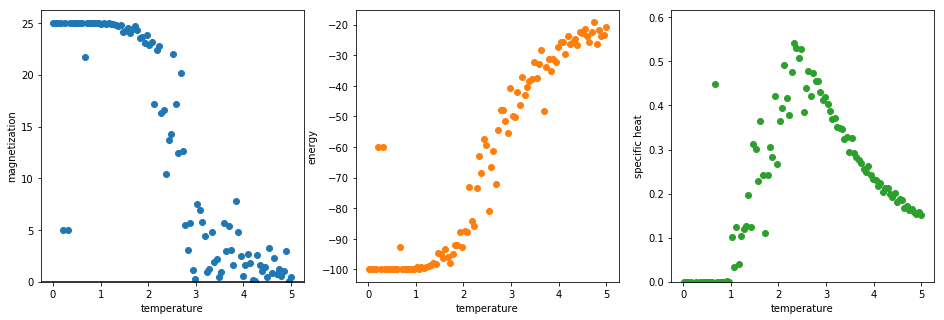

In [31]:
temperatures = np.linspace(0.01, 5, 100)
mag_avg, energy_avg, c_avg = run_simulation(5, 5, 2500, 2500, temperatures)
plot_averages(mag_avg, energy_avg, c_avg, temperatures)

We can also write a more efficient simulation that computes $E$, $M$, and $C$ by evaluating the local changes made at each step rather than recomputing them globally every step:

In [32]:
def run_simulation(N, M, tEq, Nsteps, temperatures, J=1, H=0):
    """
    Run a 'simulation' of the Ising model, taking averages of E, M and C
    
    Arguments:
        N, M           size of lattice
        tEq            steps to reach equilibrium
        Nsteps         steps to average over after equilibrium
        temperatures   array of temperature values
    """
    mag_avg = np.zeros_like(temperatures)
    energy_avg = np.zeros_like(temperatures)
    c_avg = np.zeros_like(temperatures)

    for i,temperature in enumerate(tqdm(temperatures)):
        lattice = random_lattice(N, M)

        for t in range(tEq):
            update_lattice(lattice, T=temperature, J=J, H=H)
        
        delta_E = np.zeros(Nsteps, dtype=float)
        delta_M = np.zeros(Nsteps, dtype=float)
        mag_initial = magnetization(lattice)
        energy_initial = total_energy_numpy(energy_density_numpy(lattice, J=J, H=H))
        
        for t in range(Nsteps):
            delta_E[t], delta_M[t] = update_lattice(lattice, T=temperature, J=J, H=H)

        mag = mag_initial + np.cumsum(delta_M)
        energy = energy_initial + np.cumsum(delta_E)
        
        
        mag_avg[i] = np.average(mag)
        energy_avg[i] = np.average(energy)
        c_avg[i] = np.var(energy)/temperature**2
        
    return mag_avg, energy_avg, c_avg

100%|██████████| 100/100 [00:07<00:00, 13.48it/s]


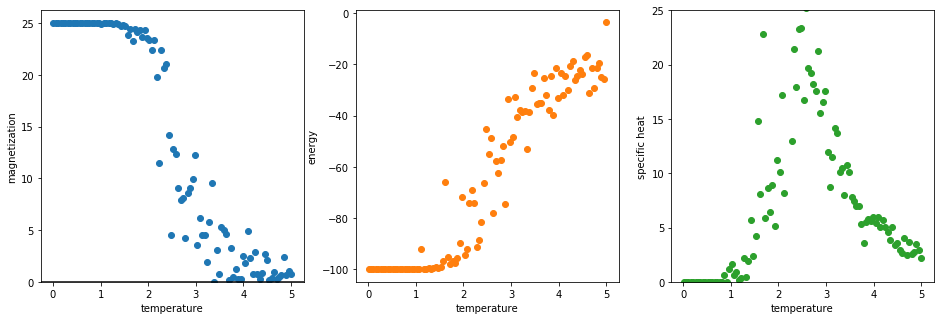

In [33]:
temperatures = np.linspace(0.01, 5, 100)
mag_avg, energy_avg, c_avg = run_simulation(5, 5, 2500, 2500, temperatures)
plot_averages(mag_avg, energy_avg, c_avg, temperatures)

# Larger lattices

Let's look at the time-evolution of a larger lattice to look for region formation. Generally, these will take a lot longer to converge. It may be that the final equilibrium is all spin up or all spin down, but you will see complex region formation along the way.

100%|██████████| 50000/50000 [00:00<00:00, 64202.40it/s]


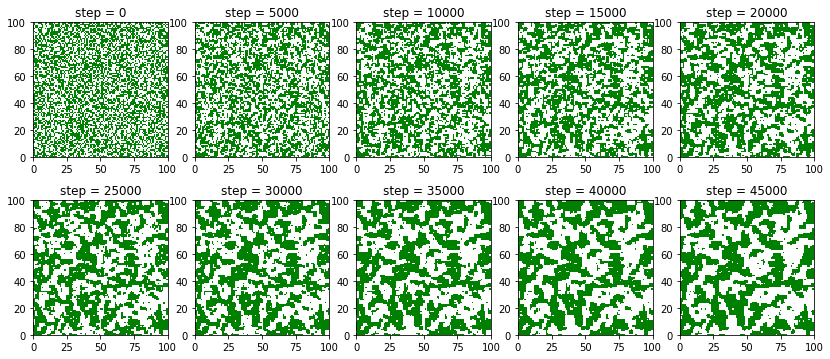

In [34]:
N, M = 100, 100
time_series_plots(N, M, Nsteps=50000, T=1)

Run the same example over many more steps, and you'll see that the system is still converging towards equilibrium

100%|██████████| 2500000/2500000 [00:39<00:00, 62555.82it/s]


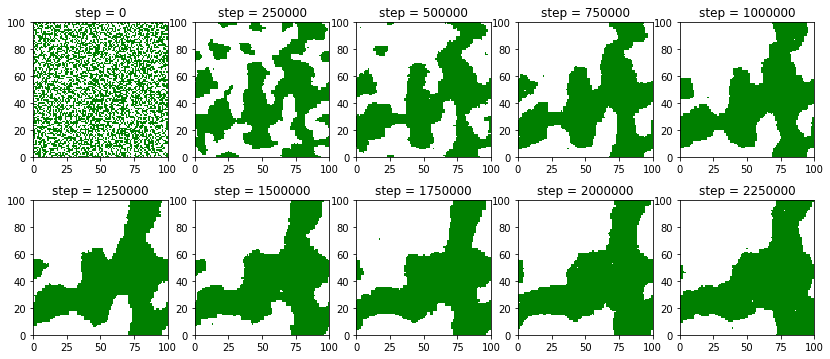

In [35]:
N, M = 100, 100
time_series_plots(N, M, Nsteps=2500000, T=1)

If we attempt to compute the average quantities for this lattice, we likely won't get good results without taking an enormous number of steps. Here we try it with $t_{eq} = 250,000$

100%|██████████| 100/100 [05:50<00:00,  3.52s/it]


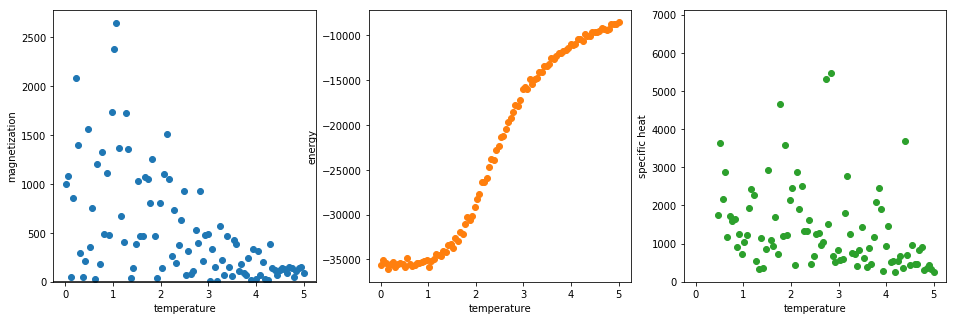

In [36]:
temperatures = np.linspace(0.01, 5, 100)
mag_avg, energy_avg, c_avg = run_simulation(100, 100, 250000, 25000, temperatures)
plot_averages(mag_avg, energy_avg, c_avg, temperatures)

# (Extra) Creating an animation of the Ising model 

For an example of how to create an animation of your lattice in time, see the `animation.py` file in this folder.

# (Extra) Simulated annealing: getting out of a local minimum

When starting the system in a random intial condition and taking many steps at a low temperature, the system will sometimes converge to a local minimum of the energy (these are responsible for the outliers in the scatter plots above). We can demonstrate this by running many different runs and plotting the final spin states. While most of the spins converge to either all spin up or all spin down (a global minimum of the energy), some converge to having regions of spin up and spin down, typically divided along horizontal or vertical lines. You can convince yourself that these states are a local minimum of the energy.

100%|██████████| 40/40 [00:01<00:00, 34.86it/s]


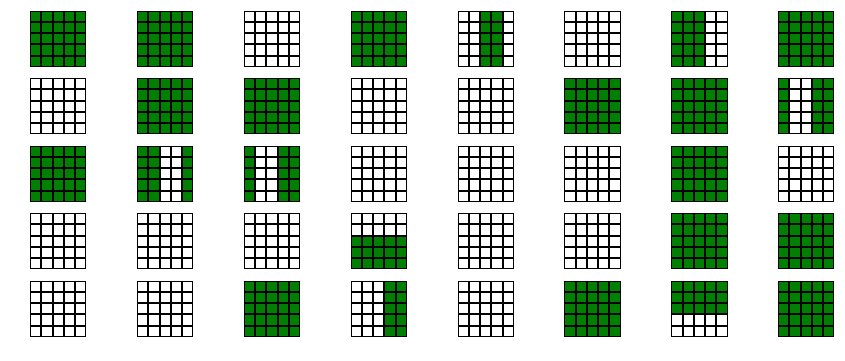

In [37]:
# repeat the same simulation 40 times at a low temperature, plotting the end state for each one
Nsteps = 1500
fig, axes = plt.subplots(ncols=8, nrows=5, figsize=(15,6))

for i in tqdm(range(40)):
    ax = axes.flatten()[i]
    lattice = random_lattice(5,5)
    for t in range(Nsteps):
        update_lattice(lattice, T=.1, J=1, H=0)
    plot_lattice(lattice, ax=ax)
    ax.axis('off')

Let's calculate the percentage of samples that reach a local minimum by looking at the total magnetization

In [38]:
local_min_count = 0   # number of simulations that converge to a local minimum
N = 500   # repeat N times

for i in tqdm(range(N)):  
    lattice = random_lattice(5,5)
    
    for t in range(Nsteps):
        update_lattice(lattice, T=.1, J=1, H=0)
        
    if abs(magnetization_per_spin(lattice)) != 1:
        local_min_count += 1
        
print('{}% reach a local minimum'.format(local_min_count/N*100))

100%|██████████| 500/500 [00:13<00:00, 37.75it/s]

14.6% reach a local minimum


This problem can be mitigated by using [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing). The idea is to start the temperature at a higher initial value $T_i$ and reduce the temperature slowly to the final desired temperature $T_f$. The simulation can then proceed for many more steps at the fixed temperature $T_f$. By doing this, the system has a greater chance of escaping any local minima and ultimately choosing to settle at the global minimum.

[Text(0,0.5,'temperature'), Text(0.5,0,'step')]

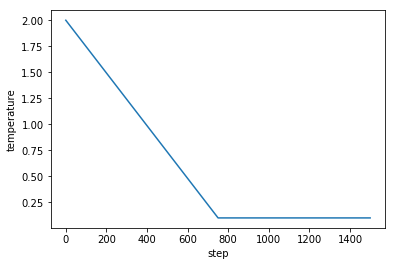

In [39]:
# a temperature function for use in simulated annealing\
# @np.vectorize is known as a 'decorator'. It allows the input arguments to be numpy arrays for this function

@np.vectorize
def Tfunc(Ti, Tf, step, end):
    """Evaluate the temperature at `step` out of `Nsteps` from `Ti` @ step=0 to `Tf` @ step=`end` """   
    if step < end:
        return Ti + (Tf - Ti)*step/end
    else:
        return Tf
    
fig, ax = plt.subplots()
ax.plot(Tfunc(2, .1, np.arange(Nsteps), Nsteps//2))
ax.set(xlabel='step', ylabel='temperature')

In [40]:
local_min_count = 0
N = 500
T = Tfunc(2, .1, np.arange(Nsteps), Nsteps//2)
for i in tqdm(range(N)):  
    lattice = random_lattice(5,5)
    
    for t in range(Nsteps):
        update_lattice(lattice, T=T[t], J=1, H=0)    # now using time-dependent temperature
        
    if abs(magnetization(lattice)) != 25:
        local_min_count += 1
        
print('{}% reach a local minimum'.format(local_min_count/N*100))

100%|██████████| 500/500 [00:13<00:00, 39.25it/s]

0.0% reach a local minimum


With simulated annealing, we manage to get every lattice to converge to the global minimum.